In [1]:
import os
import sys
import fitsio
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import astropy.io.fits as fits

from   astropy.table import Table

In [2]:
sys.path.append('{}/DESI'.format(os.environ['HOME']))

In [3]:
from schechter import schechter, named_schechter
from gama_limits import gama_field
from delta8_limits import d8_limits, delta8_tier

In [4]:
root = '{}/data/GAMA4/'.format(os.environ['HOME'])

fpath = root + 'gama_gold_ddp_n8.fits'
fpath

'/cosma/home/durham/dc-wils7/data/GAMA4/gama_gold_ddp_n8.fits'

In [5]:
#! ls /global/cscratch1/sd/mjwilson/norberg/GAMA4/

In [6]:
#ddps = fits.open(root + '/global/cscratch1/sd/mjwilson/norberg/GAMA4/gama_gold_ddp_n8.fits')
ddps = fits.open(root+'gama_gold_ddp_n8.fits')
ddps = ddps[1].header
ddps

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  393 / length of dimension 1                          
NAXIS2  =               113687 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   53 / number of table fields                         
TTYPE1  = 'CATAID  '                                                            
TFORM1  = 'J       '                                                            
TNULL1  =               999999                                                  
TTYPE2  = 'OBJID   '                                                            
TFORM2  = 'K       '        

In [7]:
#! ls /global/cscratch1/sd/mjwilson/desi/BGS/Sam

In [8]:
field = 'G9'

In [9]:
randoms = Table.read('{}/data/GAMA4/randoms/randoms_bd_ddp_n8_{}_0.fits'.format(os.environ['HOME'], field))

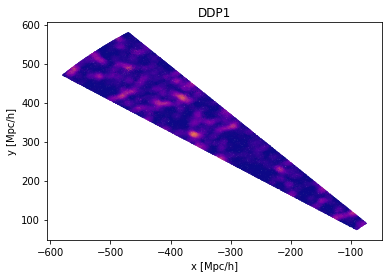

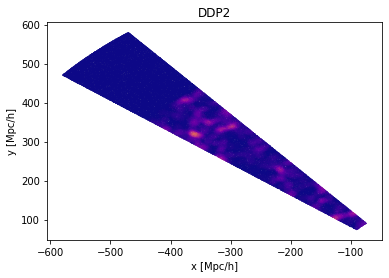

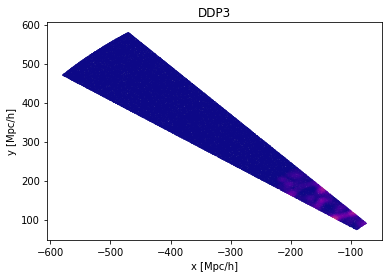

In [10]:
randoms_slice = randoms[np.abs(randoms['CARTESIAN_Z']) < 5.]

for idx in np.arange(1, 4, 1):
    plt.scatter(randoms_slice['CARTESIAN_X'],\
                randoms_slice['CARTESIAN_Y'],\
                c=randoms_slice['DDP{}_DELTA8'.format(idx)],\
                marker='.',\
                lw=0.0,\
                s=1,\
                vmin=-1.,\
                vmax=10.,\
                cmap='plasma')

    pl.xlabel('x [Mpc/h]')
    pl.ylabel('y [Mpc/h]')
    
    plt.title('DDP{}'.format(idx))
    plt.show()

Text(0.5, 1.0, 'G9 GAMA Field')

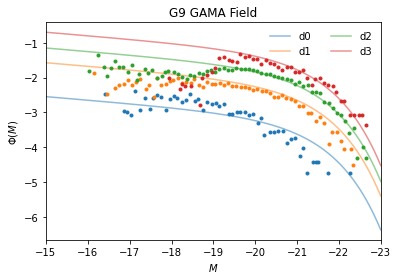

In [12]:
colors   = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in np.arange(0, 4, 1):
    ddp  = Table.read(root + 'gama_gold_{}_ddp_n8_d0_{}.fits'.format(field, i))
    vmax = Table.read(root + 'gama_gold_{}_ddp_n8_d0_{}_vmax.fits'.format(field, i), 'VMAX')
    lf   = Table.read(root + 'gama_gold_{}_ddp_n8_d0_{}_lumfn.fits'.format(field, i), 'VMAX')
    ref  = Table.read(root + 'gama_gold_{}_ddp_n8_d0_{}_lumfn.fits'.format(field, i), 'REFERENCE')
    
    lf   = lf[lf['N'] > 0]
    
    pl.plot(ref['MS'], np.log10(ref['d{}_REFSCHECHTER'.format(i)]), label='d{}'.format(i), alpha=0.5, c=colors[i])
    pl.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', marker='.', lw=0.0, c=colors[i])

pl.xlabel(r'$M$')
pl.ylabel(r'$\Phi(M)$')

pl.xlim(-15., -23.0)
# pl.ylim(-3.0,   -.5)

pl.legend(frameon=False, loc=1, ncol=2)
pl.title('{} GAMA Field'.format(field))

In [30]:
vmax.meta

OrderedDict([('EXTNAME', 'TilingCat'),
             ('TCOMM1', 'GAMA ID'),
             ('TUCD1', 'meta.id;meta.main'),
             ('TCOMM2', 'SDSS objid'),
             ('TUCD2', 'meta.id'),
             ('TCOMM3', 'J2000 coordinate'),
             ('TUCD3', 'pos.eq.ra'),
             ('TCOMM4', 'J2000 coordinate'),
             ('TUCD4', 'pos.eq.dec'),
             ('TCOMM5', '3-arcsec fiber magnitude'),
             ('TUCD5', 'phot.mag;em.opt.R'),
             ('TCOMM6', 'Extinction-corrected SDSS DR7 Petrosian mag'),
             ('TUCD6', 'phot.mag;em.opt.R'),
             ('TCOMM7', 'Extinction-corrected SDSS DR7 mag'),
             ('TUCD7', 'phot.mag;em.opt.U'),
             ('TCOMM8', 'Extinction-corrected SDSS DR7 mag'),
             ('TUCD8', 'phot.mag;em.opt.B'),
             ('TCOMM9', 'Extinction-corrected SDSS DR7 mag'),
             ('TUCD9', 'phot.mag;em.opt.R'),
             ('TCOMM10', 'Extinction-corrected SDSS DR7 mag'),
             ('TUCD10', 'phot.mag;em.opt.I

(array([ 35.,  26.,  11.,  39.,  29., 111.,  31.,  64., 310., 242., 283.,
        108., 118.,  86., 110.,  67.,  60.,  89.,  53.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 [<matplotlib.patches.Polygon at 0x7f2c2b298f70>])

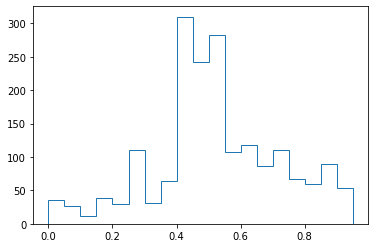

In [24]:
pl.hist(vmax['VZ'] / vmax['VMAX'], histtype='step', bins=np.arange(0., 1., 0.05))

In [16]:
lf.meta

OrderedDict([('EXTNAME', 'VMAX'),
             ('TCOMM1', 'GAMA ID'),
             ('TUCD1', 'meta.id;meta.main'),
             ('TCOMM2', 'SDSS objid'),
             ('TUCD2', 'meta.id'),
             ('TCOMM3', 'J2000 coordinate'),
             ('TUCD3', 'pos.eq.ra'),
             ('TCOMM4', 'J2000 coordinate'),
             ('TUCD4', 'pos.eq.dec'),
             ('TCOMM5', '3-arcsec fiber magnitude'),
             ('TUCD5', 'phot.mag;em.opt.R'),
             ('TCOMM6', 'Extinction-corrected SDSS DR7 Petrosian mag'),
             ('TUCD6', 'phot.mag;em.opt.R'),
             ('TCOMM7', 'Extinction-corrected SDSS DR7 mag'),
             ('TUCD7', 'phot.mag;em.opt.U'),
             ('TCOMM8', 'Extinction-corrected SDSS DR7 mag'),
             ('TUCD8', 'phot.mag;em.opt.B'),
             ('TCOMM9', 'Extinction-corrected SDSS DR7 mag'),
             ('TUCD9', 'phot.mag;em.opt.R'),
             ('TCOMM10', 'Extinction-corrected SDSS DR7 mag'),
             ('TUCD10', 'phot.mag;em.opt.I'),
 

In [13]:
Ms = np.arange(-25.5, -15.5 , 0.1)
bin_centres =  (Ms[1:]+Ms[:-1])/2
colour = ['blue', 'orange', 'green', 'red']

for idx in range(4):
    LF_G9  = Table.read(root + 'gama_gold_G9_ddp_n8_d0_{}_lumfn.fits'.format(idx))
    LF_G12 = Table.read(root + 'gama_gold_G12_ddp_n8_d0_{}_lumfn.fits'.format(idx))
    LF_G15 = Table.read(root + 'gama_gold_G15_ddp_n8_d0_{}_lumfn.fits'.format(idx))

    x =np.c_[bin_centres, np.array(LF_G9['PHI_IVMAX']), np.array(LF_G12['PHI_IVMAX']), np.array(LF_G15['PHI_IVMAX'])]
    #x=np.c_[bin_centres, np.array(LF_G9['PHI_IVMAX']/LF_G9['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G12['PHI_IVMAX']/LF_G12['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G15['PHI_IVMAX']/LF_G15['d{}_REFSCHECHTER'.format(idx)])]

    
    x_ref=np.c_[bin_centres, np.array(LF_G9['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G12['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G15['d{}_REFSCHECHTER'.format(idx)])]

    
    #x=np.c_[bin_centres, np.array(LF_G9['PHI_IVMAX']/LF_G9['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G12['PHI_IVMAX']/LF_G12['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G15['PHI_IVMAX']/LF_G15['d{}_REFSCHECHTER'.format(idx)])]

    LF_mean = np.mean(x[:,1:], axis=1)
    LF_std = np.std(x[:,1:], axis=1) / np.sqrt(3)

    LF_ref_mean = np.mean(x_ref[:,1:], axis=1)
    LF_ref_std = np.std(x_ref[:,1:], axis=1) / np.sqrt(3)
    
    pl.plot(bin_centres, np.log10(LF_mean), label='d{}'.format(idx), color=colour[idx])
    pl.plot(bin_centres, np.log10(LF_ref_mean), alpha=0.5, color=colour[idx])
    #pl.errorbar(bin_centres, np.log10(LF_mean), np.log10(LF_std), label='d{}'.format(idx))
    
    #pl.errorbar(gama_lf['MEDIAN_M'], np.log10(gama_lf['PHI_N']), gama_lf['PHI_N_ERROR'] / gama_lf['PHI_N'] / np.log(10.), label='NOWEIGHT', alpha=0.4)
    #pl.errorbar(gama_lf['MEDIAN_M'], np.log10(gama_lf['PHI_IVMAX']), gama_lf['PHI_IVMAX_ERROR'] / gama_lf['PHI_IVMAX'] / np.log(10.), label='IVMAX')

    

plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=14)
plt.ylabel(r'log $\phi(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=14)

plt.title(r'GAMA DDP LFs (All Fields)')

#pl.ylim(-4.25, -.75)
#pl.xlim(-23., -15.5)
pl.gca().invert_xaxis()
pl.legend(frameon=True, loc=2)
pl.show()

KeyError: 'd0_REFSCHECHTER'

In [14]:
for idx in range(4):
    LF_G9  = Table.read(root + 'gama_gold_G9_ddp_n8_d0_{}_lumfn.fits'.format(idx))
    LF_G12 = Table.read(root + 'gama_gold_G12_ddp_n8_d0_{}_lumfn.fits'.format(idx))
    LF_G15 = Table.read(root + 'gama_gold_G15_ddp_n8_d0_{}_lumfn.fits'.format(idx))

    #x =np.c_[bin_centres, np.array(LF_G9['PHI_IVMAX']), np.array(LF_G12['PHI_IVMAX']), np.array(LF_G15['PHI_IVMAX'])]
    x=np.c_[bin_centres, np.array(LF_G9['PHI_IVMAX']/LF_G9['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G12['PHI_IVMAX']/LF_G12['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G15['PHI_IVMAX']/LF_G15['d{}_REFSCHECHTER'.format(idx)])]

    #x_ref=np.c_[bin_centres, np.array(LF_G9['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G12['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G15['d{}_REFSCHECHTER'.format(idx)])]

    
    #x=np.c_[bin_centres, np.array(LF_G9['PHI_IVMAX']/LF_G9['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G12['PHI_IVMAX']/LF_G12['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G15['PHI_IVMAX']/LF_G15['d{}_REFSCHECHTER'.format(idx)])]

    LF_mean = np.mean(x[:,1:], axis=1)
    LF_std = np.std(x[:,1:], axis=1) / np.sqrt(3)

    #LF_ref_mean = np.mean(x_ref[:,1:], axis=1)
    #LF_ref_std = np.std(x_ref[:,1:], axis=1) / np.sqrt(3)
    
    pl.plot(bin_centres, np.log10(LF_mean), label='d{}'.format(idx), color=colour[idx])
    #pl.plot(bin_centres, np.log10(LF_ref_mean), alpha=0.5, color=colour[idx])
    #pl.errorbar(bin_centres, np.log10(LF_mean), np.log10(LF_std), label='d{}'.format(idx))
    
    #pl.errorbar(gama_lf['MEDIAN_M'], np.log10(gama_lf['PHI_N']), gama_lf['PHI_N_ERROR'] / gama_lf['PHI_N'] / np.log(10.), label='NOWEIGHT', alpha=0.4)
    #pl.errorbar(gama_lf['MEDIAN_M'], np.log10(gama_lf['PHI_IVMAX']), gama_lf['PHI_IVMAX_ERROR'] / gama_lf['PHI_IVMAX'] / np.log(10.), label='IVMAX')

    

plt.xlabel(r'$M_r$ - 5 log(h)', fontsize=14)
plt.ylabel(r'log $\phi(L) / \phi_0(L)$ [h$^3$ Mpc$^{-3}$ Mag$^{-1}$]', fontsize=14)

plt.title(r'GAMA DDP LFs (All Fields)')

#pl.ylim(-4.25, -.75)
#pl.xlim(-23., -15.5)
pl.gca().invert_xaxis()
pl.legend(frameon=True, loc=2)
pl.show()

KeyError: 'd0_REFSCHECHTER'

# Done.